[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dhruv9vats/misc/blob/main/multitaper_example.ipynb)

If clicking the link above turns the screen gray, try right clicking on the link and selecting "Open link in new tab".

## Install Stingray in colab
Comment out the cell below if running locally.

In [1]:
# %%capture --no-display
# !git clone --recursive https://github.com/StingraySoftware/stingray.git
# %cd stingray
# !pip install astropy scipy matplotlib numpy pytest pytest-astropy h5py tqdm seaborn
# !pip install -e "."
# %cd ..

# import os
# os.kill(os.getpid(), 9)

__The kernel will (crash and then) restart after executing the above cell to finish installing Stingray. So the cells below will have to be run again or manually.__

## Multitaper Spectral Estimator Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette("husl", 8)

import scipy
from scipy import signal
from stingray import Multitaper, Powerspectrum, Lightcurve

### Creating a light curve  
---
Lets create a `Lightcurve` sampled from an autoregressive process of order 4 that has been frequently exemplified in literature in similar contexts

/home/saurav/.local/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<Axes: xlabel='Time (s)', ylabel='counts'>

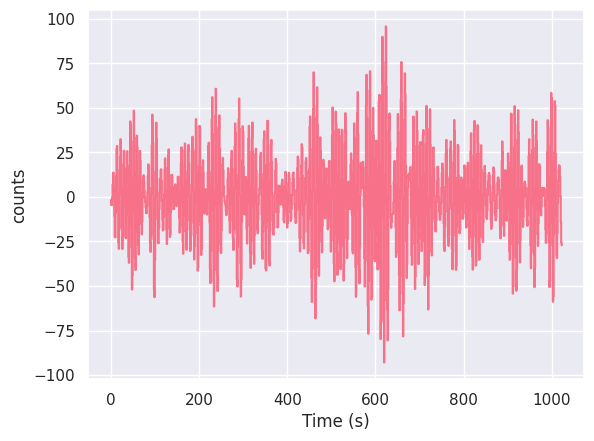

In [3]:
np.random.seed(100)
coeff = np.array([2.7607, -3.8106, 2.6535, -0.9238]) # The 4 coefficients for the AR(4) process
ar4 = np.r_[1, -coeff] # For use with scipy.signal
N = 1024

freq_analytical, h = signal.freqz(b=1.0, a=ar4, worN=N, fs=1) # True PSD of AR(4)
psd_analytical = (h * h.conj()).real

data = signal.lfilter([1.0], ar4, np.random.normal(0, 1, N)) # N AR(4) data samples.

times = np.arange(N)

err = np.random.normal(0, 1, N)

lc_ar4 = Lightcurve(time=times, counts=data, err_dist='gauss', err=err)
lc_ar4.plot()

### The Multitaper Periodogram  

Tapering a time series as a way of obtaining a spectral estimator with acceptable bias properties is an important concept. While tapering does reduce bias due to leakage, there is a price to pay in that the sample size is effectively reduced. The loss of information inherent in tapering can often be avoided either by prewhitening or by using Welch's overlapped segment averaging.

The multitaper periodogram is another approach to recover information lost due to tapering. This apporach was introduced by Thomson (1982) and involves the use of multiple orthogonal tapers.

In the multitaper method the data is windowed or tapered, but this method differs from the traditional methods in the tapers used, which are the most band-limited functions amongst those defined on a finite time domain, and also, these tapers are orthogonal, enabling us to average the _eigenspectrum_ (spectrum estimates from individual tapers) from more than one tapers to obtain a superior estimate in terms of noise. The resulting spectrum has low leakage, low variance, and retains information contained in the beginning and end of the time series. For more details on the multitaper periodogram, please have a look at the references.

##### Let's have a look at the individual tapers.

In [4]:
NW = 4 # normalized half-bandwidth = 4
Kmax = 8 # Number of tapers
dpss_tapers, eigvals = \
signal.windows.dpss(M=lc_ar4.n, NW=NW, Kmax=Kmax,
                    sym=False, return_ratios=True)

data_multitaper = lc_ar4.counts - np.mean(lc_ar4.counts)  # De-mean
data_multitaper = np.tile(data_multitaper, (len(eigvals), 1))

 # Data tapered with the dpss windows
data_multitaper = np.multiply(data_multitaper, dpss_tapers)

Plotted below are the first 8 tapers (on the left), and the corresponding tapered time series

/tmp/ipykernel_34495/3713784415.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


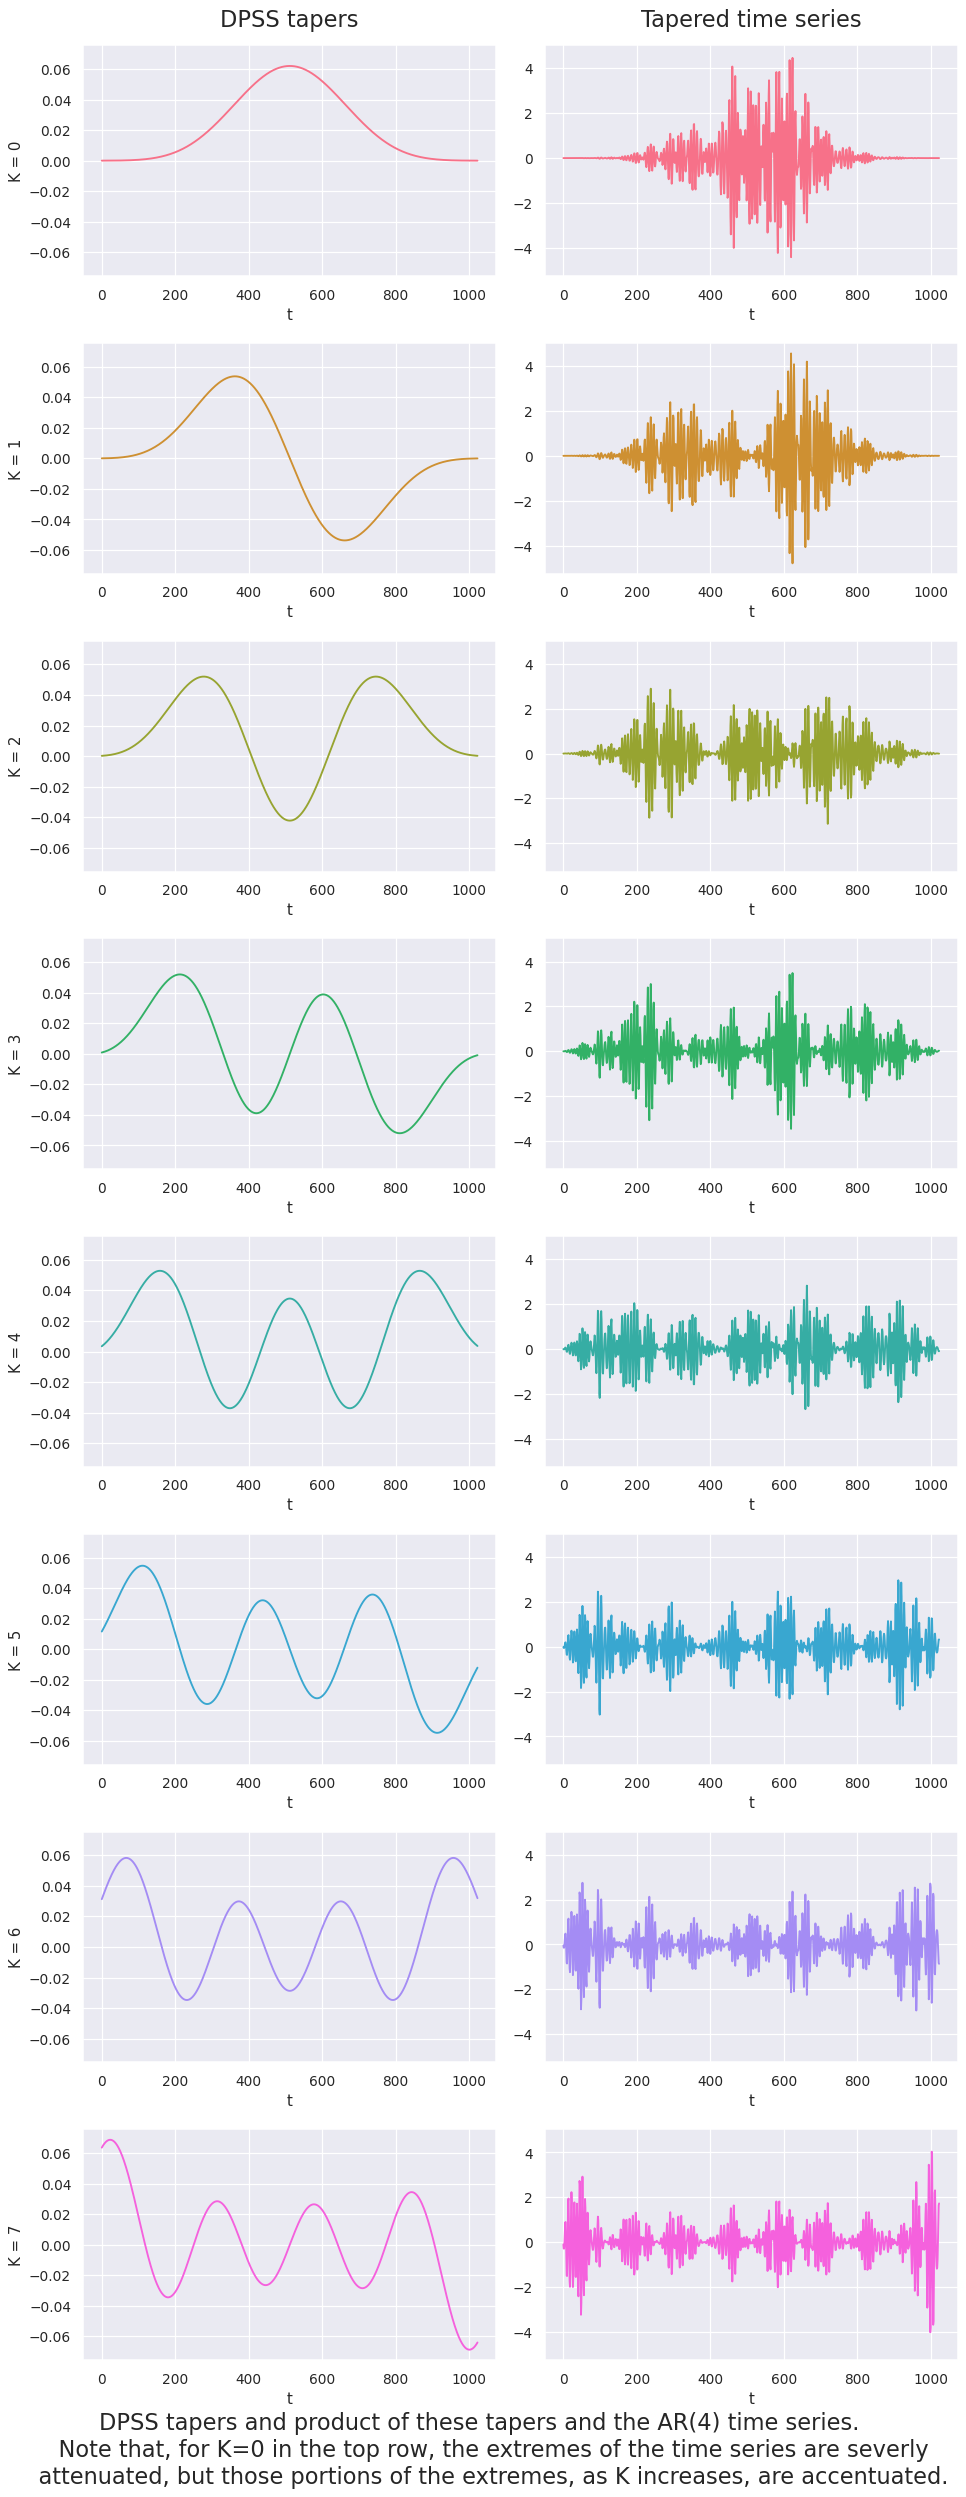

In [5]:
fig, axes = plt.subplots(8, 2, figsize=(11, 27), dpi=90, sharey='col')

idx = 0
palette = sns.color_palette("husl", 8)
for taper, tapered_data, axes_rows in zip(dpss_tapers, data_multitaper, axes):
    axes_rows[0].plot(lc_ar4.time, taper, color=palette[idx])
    axes_rows[0].set_ylabel(f"K = {idx}")
    axes_rows[0].set_xlabel("t")
    
    axes_rows[1].plot(lc_ar4.time, tapered_data, color=palette[idx])
    axes_rows[1].set_xlabel("t")
    
    idx += 1
axes[0][0].set_title("DPSS tapers", fontsize=18, pad=15)
axes[0][1].set_title("Tapered time series", fontsize=18, pad=15)
fig.tight_layout()
txt="DPSS tapers and product of these tapers and the AR(4) time series.\n\
    Note that, for K=0 in the top row, the extremes of the time series are severly\n\
    attenuated, but those portions of the extremes, as K increases, are accentuated."
fig.text(.5, -0.025, txt, ha='center', fontsize=18)
fig.show();

#### Now let's see their frequency domain representations (here PSD)

We can have a good look at the leakage properties of these tapers (and the resulting time series) from their PSD representations.

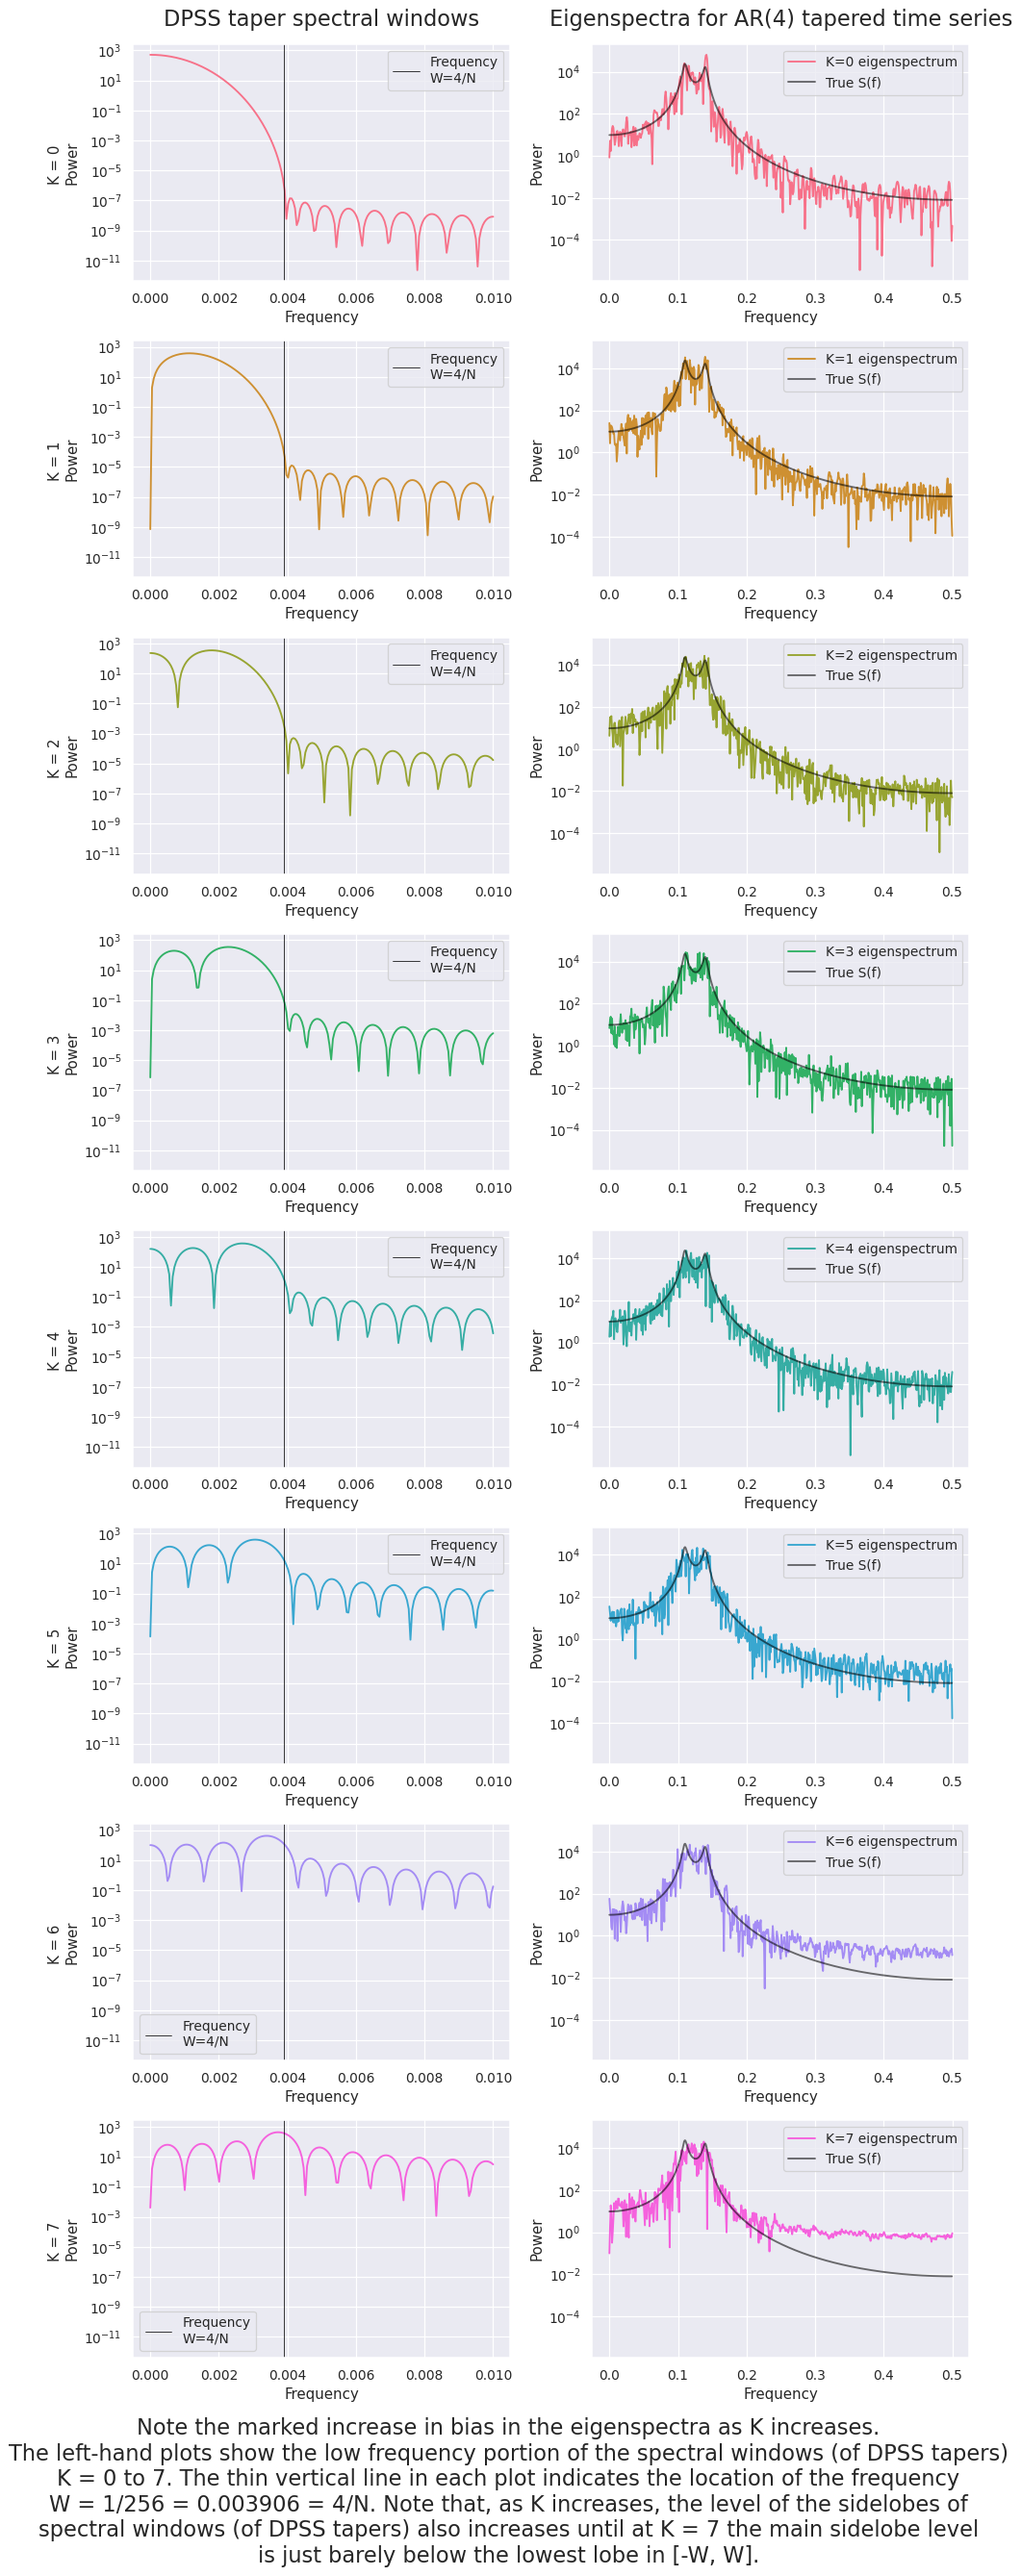

In [6]:
%%capture --no-display
fig, axes = plt.subplots(8, 2, figsize=(11, 28), dpi=90, sharey='col')

idx = 0
palette = sns.color_palette("husl", 8)

freq = scipy.fft.rfftfreq(lc_ar4.n, d=lc_ar4.dt)
for taper, tapered_data, axes_rows in zip(dpss_tapers, data_multitaper, axes):

    w, h = signal.freqz(taper, fs=1, worN=np.linspace(0, 0.01, 200))
    h = np.multiply(h, np.conj(h))
    axes_rows[0].plot(w, h, color=palette[idx])
    axes_rows[0].axvline(x=NW/N, color="black", linewidth=0.6, label="Frequency\nW=4/N")
    axes_rows[0].set(
        ylabel=f"K = {idx} \nPower",
        xlabel="Frequency",
        yscale="log"
    )
    axes_rows[0].legend()
    
    fft_tapered_data = scipy.fft.rfft(tapered_data)
    psd_tapered_data = np.multiply(fft_tapered_data, np.conj(fft_tapered_data))
    axes_rows[1].plot(freq, psd_tapered_data, color=palette[idx], label=f"K={idx} eigenspectrum")
    axes_rows[1].plot(freq_analytical, psd_analytical, color="black", alpha=0.56, label="True S(f)")
    axes_rows[1].set(
        xlabel="Frequency",
        ylabel="Power",
        yscale="log"
    )
    axes_rows[1].legend()
    
    idx += 1
# fig.suptitle("Left: DPSS taper spectral windows \n Right: Eigenspectra for AR(4) time series with given K", y=1)
axes[0][0].set_title("DPSS taper spectral windows", fontsize=18, pad=15)
axes[0][1].set_title("Eigenspectra for AR(4) tapered time series", fontsize=18, pad=15)

text="Note the marked increase in bias in the eigenspectra as K increases.\n\
The left-hand plots show the low frequency portion of the spectral windows (of DPSS tapers)\n\
K = 0 to 7. The thin vertical line in each plot indicates the location of the frequency\n\
W = 1/256 = 0.003906 = 4/N. Note that, as K increases, the level of the sidelobes of\n\
spectral windows (of DPSS tapers) also increases until at K = 7 the main sidelobe level\n\
is just barely below the lowest lobe in [-W, W]."
fig.text(0.5, -0.06, text, ha="center", fontsize=18)
fig.tight_layout()
fig.show();

### Summary of Multitaper Spectral Estimation
We assume that $ X_1, X_2, ..., X_N $ is a sample of length $N$ from a zero
mean real-valued stationary process $ \{X_t\} $ with unknown sdf $ S(\cdot) $ defined over the interval $[-f_{(N)}, f_{(N)}]$, where $f_{(N)} \equiv 1/(2\Delta t)$ is the Nyquist frequency and $\Delta t$ is the sampling interval between observations. (If $\{X_t\}$ has an unknown mean, we need to replace $X_t$ with $X_t' \equiv X_t - \bar{X_t}$
in all computational formulae, where $\bar{X_t} = \sum^N_{t=1}X_t/N$ is the sample mean.)  

- __Simple multitaper spectral estimator__ $\hat{S}^{mt}(\cdot)$  

This estimator is defined as the average of K
eigenspectra $\hat{S}^{mt}_k(\cdot),k = 0, ..., K - 1$, the $k^{th}$ of which is a direct spectral estimator employing a dpss data taper $\{h_{t,k}\}$ with
parameter $W$. The estimator $\hat{S}^{mt}_k(f)$ is approximately equal in
distribution to $S(f)_{\chi^2_{2K}}/2K$  

- __Adaptive multitaper spectral estimator__ $\hat{S}^{amt}(\cdot)$  

This estimator uses the same eigenspectra as $\hat{S}^{mt}(\cdot)$, but it now adaptively weights the $\hat{S}^{mt}(\cdot)$ terms. The weight for
the $k^{th}$ eigenspectrum is proportional to $b^2_k(f)\lambda_k$, where $\lambda_k$ is the eigenvalue corresponding to the eigenvector with elements $\{h_{t,k}\}$, while $b_k(f)$ is given by  


<div align="center"> 
    $\large{b_k(f) = \frac {S(f)} {\lambda_k S(f) + (1-\lambda_k)\sigma^2\Delta t}}$
</div>
    
The $b_k(f)$ term depends on the unknown sdf $S(f)$, but it is estimated using an iterative scheme. The estimator $\hat{S}^{mt}_k(f)$ is approximately equal in distribution to $S(f)_{\chi^2_\nu}/\nu$.

This summary, by no means, is an exhaustive explanation of the multitapering concept. Further exploration of the topic is highly encouraged. Use the references as the starting point.

## Creating a `Multitaper` object

Pass the `Lightcurve` object to the `Multitaper` constructor
### Other (optional) parameters that can be set at instantiation are:
(Given here for completness, feel free to skip as they are later showcased)

`norm`: {`leahy` | `frac` | `abs` | `none` }, optional, default ``frac``  
    The normaliation of the power spectrum to be used. Options are
    ``leahy``, ``frac``, ``abs`` and ``none``, default is ``frac``. 
        
`NW`: float, optional, default ``4``    
    The normalized half-bandwidth of the data tapers, indicating a
    multiple of the fundamental frequency of the DFT (Fs/N).
    Common choices are n/2, for n >= 4.
    
`adaptive`: boolean, optional, default ``False``  
    Use an adaptive weighting routine to combine the PSD estimates of
    different tapers.  
    
`jackknife`: boolean, optional, default ``True``  
    Use the jackknife method to make an estimate of the PSD variance
    at each point.  
    
`low_bias`: boolean, optional, default ``True``  
    Rather than use 2NW tapers, only use the tapers that have better than
    90% spectral concentration within the bandwidth (still using
    a maximum of 2NW tapers)  
    
`lombscargle`: boolean, optional, default ``False``  
    Whether to use the Lomb (1976) Scargle (1982) periodogram when
    calculating the Multitaper spectral estimate. Highly recommended for
    unevenly sampled time-series. Adaptive weighting and jack-knife
    estimated variance are yet not supported.  

In [7]:
mtp = Multitaper(lc_ar4, adaptive=True, norm="abs")
print(mtp)

Using 7 DPSS windows for multitaper spectrum estimator
Multitaper
__________
freq           : [0.00097656 ... 0.49902344] (size 511)
jk_var_deg_freedom: [0.1445627  ... 2.68888695] (size 511)
multitaper_norm_power: [2.72203786e+01 ... 3.93250147e-03] (size 511)
power          : [5.44407571e+01 ... 7.86500295e-03] (size 511)
power_err      : [5.44407571e+01 ... 7.86500295e-03] (size 511)
unnorm_power   : [2.78736676e+04 ... 4.02688151e+00] (size 511)
df             : 0.0009765625
dt             : 1.0
eigvals        : [1.        ... 0.9366554] (size 7)
err_dist       : gauss
fullspec       : False
gti            : [[-5.0000e-01  1.0235e+03]] (shape (1, 2))
k              : 1
m              : 1
meancounts     : -0.07166224267539037
n              : 1024
norm           : abs
nphots         : -73.38213649959974
power_type     : real
type           : powerspectrum
var            : 4.006142803498701e-05



/home/saurav/.local/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


### The results

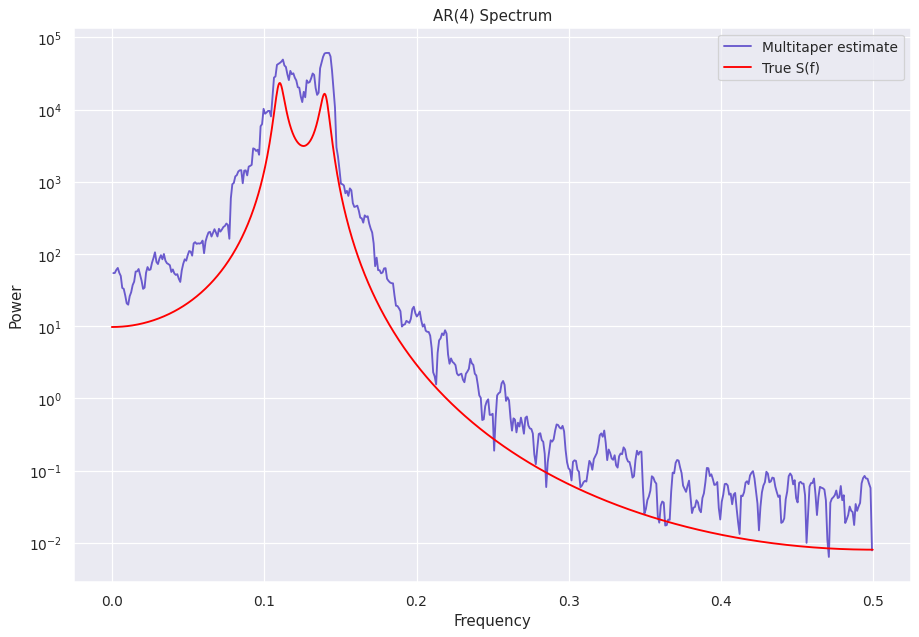

In [8]:
fig = plt.figure(figsize=(12, 8), dpi=90)
plt.plot(mtp.freq, mtp.power, color="slateblue", label="Multitaper estimate")
plt.plot(freq_analytical, psd_analytical, color="red", label="True S(f)")
plt.yscale("log")
plt.legend()
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("AR(4) Spectrum")
plt.show();

### While it seems decent, lets compare with `Powerspectrum`

In [9]:
ps = Powerspectrum(lc_ar4, norm="abs")

Text(0.5, 1.0, 'AR(4) Spectrum')

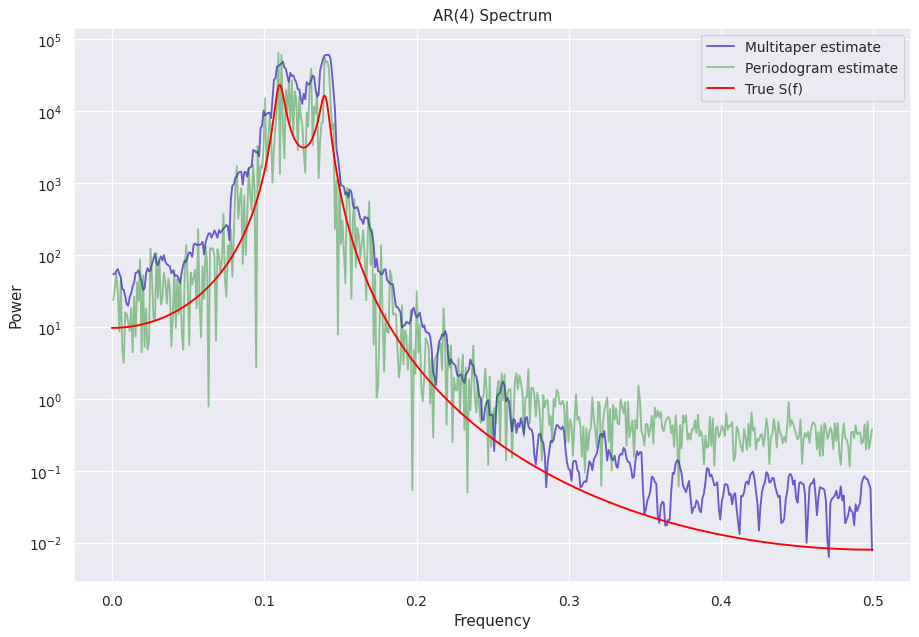

In [10]:
fig = plt.figure(figsize=(12, 8), dpi=90)
plt.plot(mtp.freq, mtp.power, color="slateblue", label="Multitaper estimate")
plt.plot(ps.freq, ps.power, color="green", label="Periodogram estimate", alpha=0.4)
plt.plot(freq_analytical, psd_analytical, color="red", label="True S(f)")
plt.legend()
plt.yscale("log")
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("AR(4) Spectrum")

##### As can be seen, there is improvement in both the variance and the bias.

### Attributes of the Multitaper object
``norm``: {``leahy`` | ``frac`` | ``abs`` | ``none`` }
        the normalization of the power spectrun

``freq``: The array of mid-bin frequencies that the Fourier transform samples

``power``: The array of normalized squared absolute values of Fourier
amplitudes

``unnorm_power``: The array of unnormalized values of Fourier amplitudes

``multitaper_norm_power``:The array of normalized values of Fourier amplitudes, normalized
    according to the scheme followed in nitime, that is, by the length and
    the sampling frequency.

``power_err``: The uncertainties of ``power``.
    An approximation for each bin given by ``power_err = power/sqrt(m)``.
    Where ``m`` is the number of power averaged in each bin (by frequency
    binning, or averaging power spectrum). Note that for a single
    realization (``m=1``) the error is equal to the power.

``df``: The frequency resolution

``m``: The number of averaged powers in each bin

``n``: The number of data points in the light curve

``nphots``: The total number of photons in the light curve

``jk_var_deg_freedom``: Array differs depending on whether
the jackknife was used. It is either
- The jackknife estimated variance of the log-psd, OR
- The degrees of freedom in a chi2 model of how the estimated
  PSD is distributed about the true log-PSD (this is either
  2\*floor(2\*NW), or calculated from adaptive weights)

### A look at the values contained in these attributes.

In [11]:
print(mtp)
print("norm: ", mtp.norm, type(mtp.norm))
print("power.shape: ", mtp.power.shape, type(mtp.power))
print("unnorm_power.shape: ", mtp.unnorm_power.shape, type(mtp.unnorm_power))
print("multitaper_norm_power.shape: ", mtp.multitaper_norm_power.shape, type(mtp.multitaper_norm_power))
print("power_err.shape: ", mtp.power_err.shape, type(mtp.power_err))
print("df: ", mtp.df, type(mtp.df))
print("m: ", mtp.m, type(mtp.m))
print("n: ", mtp.n, type(mtp.n)) # Notice the length of PSDs is half that of the number of data points in the light curve, as the imaginary (complex) part is discarded.
print("nphots: ", mtp.nphots, type(mtp.nphots))
print("jk_var_deg_freedom.shape: ", mtp.jk_var_deg_freedom.shape, type(mtp.jk_var_deg_freedom))

Multitaper
__________
freq           : [0.00097656 ... 0.49902344] (size 511)
jk_var_deg_freedom: [0.1445627  ... 2.68888695] (size 511)
multitaper_norm_power: [2.72203786e+01 ... 3.93250147e-03] (size 511)
power          : [5.44407571e+01 ... 7.86500295e-03] (size 511)
power_err      : [5.44407571e+01 ... 7.86500295e-03] (size 511)
unnorm_power   : [2.78736676e+04 ... 4.02688151e+00] (size 511)
df             : 0.0009765625
dt             : 1.0
eigvals        : [1.        ... 0.9366554] (size 7)
err_dist       : gauss
fullspec       : False
gti            : [[-5.0000e-01  1.0235e+03]] (shape (1, 2))
k              : 1
m              : 1
meancounts     : -0.07166224267539037
n              : 1024
norm           : abs
nphots         : -73.38213649959974
power_type     : real
type           : powerspectrum
var            : 4.006142803498701e-05

norm:  abs <class 'str'>
power.shape:  (511,) <class 'numpy.ndarray'>
unnorm_power.shape:  (511,) <class 'numpy.ndarray'>
multitaper_norm_power.

### A look at the different normalizations
The normalized S(f) estimates are stored in the `power` attribute can be accessed like `mtp.power` if the object name is `mtp`

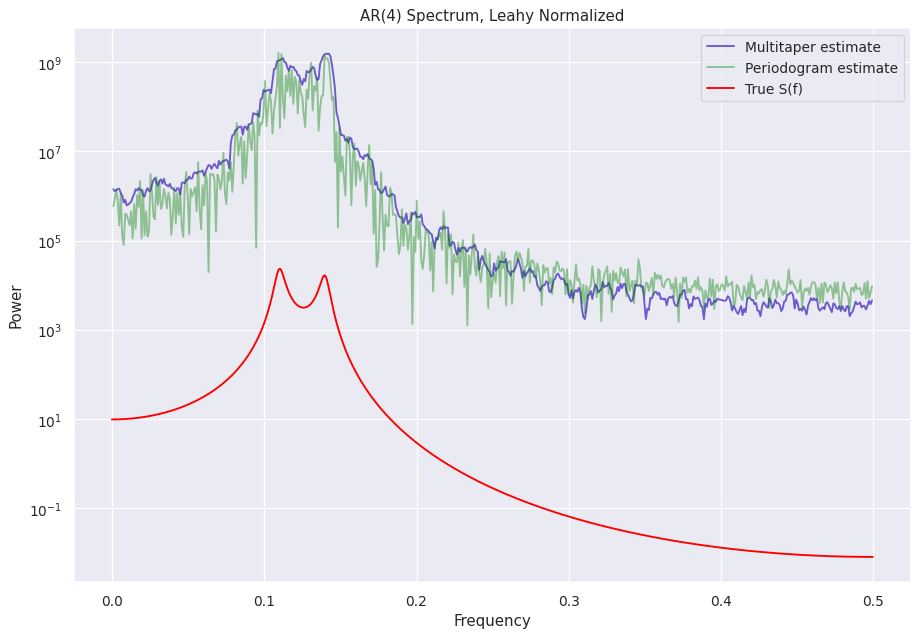

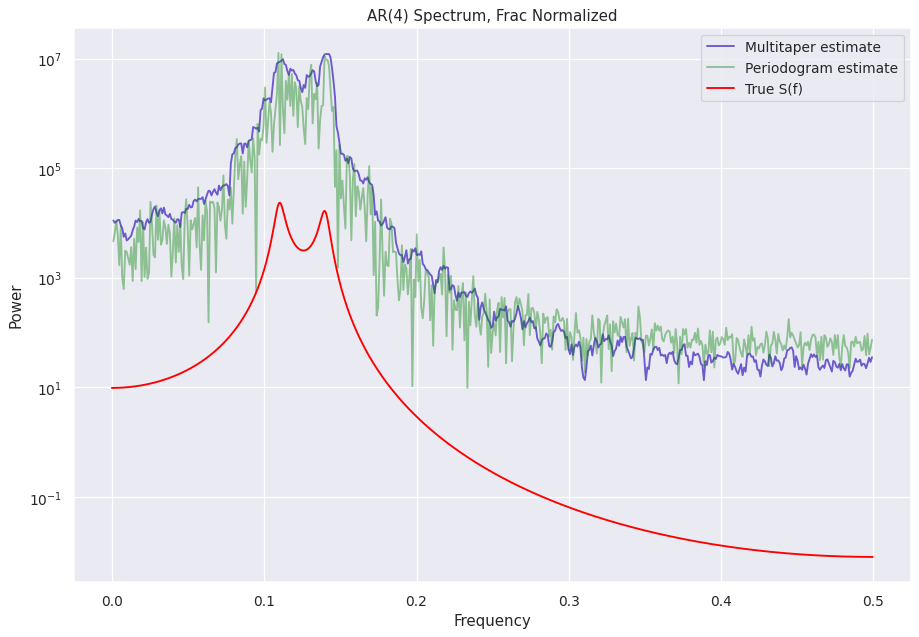

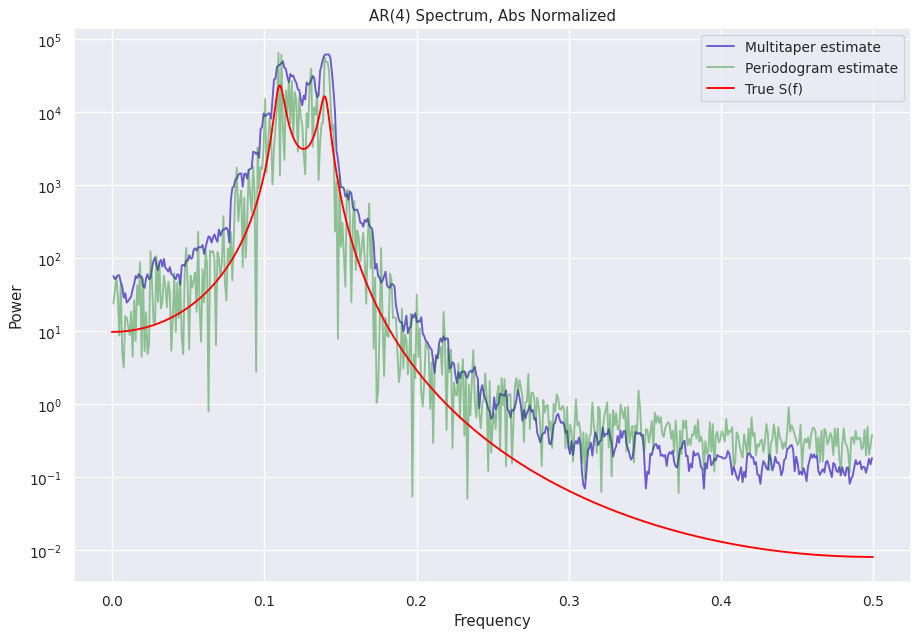

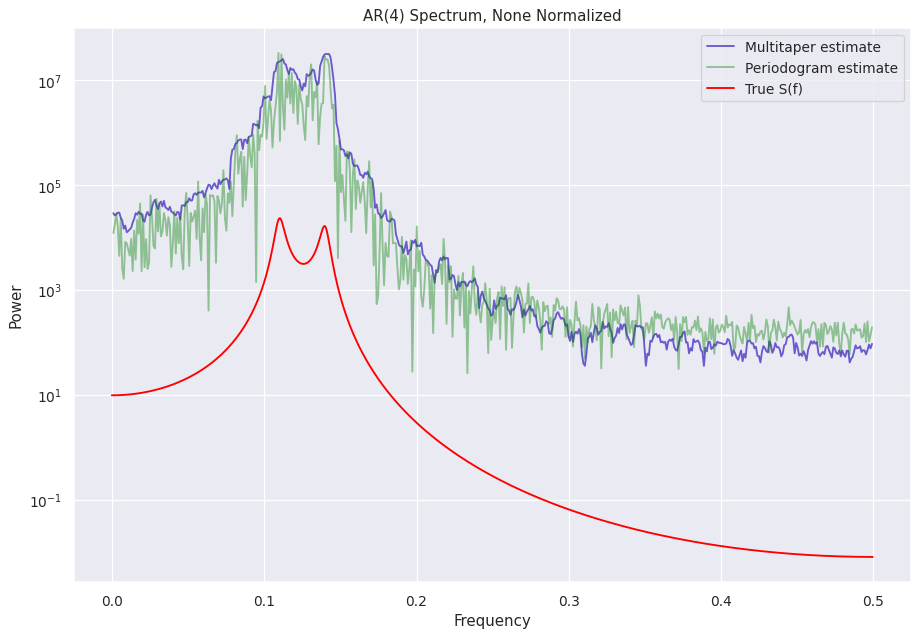

In [12]:
%%capture --no-display
norms = ["leahy", "frac", "abs", "none"]

for norm in norms:
    ps = Powerspectrum(lc_ar4, norm=norm)
    mtp = Multitaper(lc_ar4, norm=norm, adaptive=False) # adaptive=False does not calculate adaptive weights to reduce bias, helps see the normalization similarities better
    
    fig = plt.figure(figsize=(12, 8), dpi=90)
    plt.plot(mtp.freq, mtp.power, color="slateblue", label="Multitaper estimate")
    plt.plot(ps.freq, ps.power, color="green", label="Periodogram estimate", alpha=0.4)
    plt.plot(freq_analytical, psd_analytical, color="red", label="True S(f)")
    plt.legend()
    plt.yscale("log")
    plt.ylabel("Power")
    plt.xlabel("Frequency")
    plt.title("AR(4) Spectrum, " + (norm + " normalized").title())

### Other attributes with the S(f) estimates
If you look closely at the attributes of the `multitaper` object, there is a `multitaper_norm_power` attribute. This attributes contains the PSD normalized according to 


Another attribute containing the PSD is the `unnorm_power`, and as the name suggests, contains the unnormalized PSD.

## A summary of the jackknife variance estimate
Assume that we have a sample of $K$ independent observations, $\{x_i\}, i = 1,...K$, drawn from some distribution characterized by a parameter $\theta$, which is to be estimated. Here, $\theta$ is usually a spectrum or coherence at a particular frequency or a simple parameter such as the frequency of a periodic component. Denote an estimate of $\theta$ made using all $K$ observations by $\hat{\theta_{all}}$. Next, subdivide the data into $K$ groups of size $K − 1$ by deleting each entry in turn from the whole set, and let the estimate of $\theta$ with the $i$th observation deleted be
<div align="center">
    $\large{\theta_{\setminus i} = \hat{\theta}\{x_1,..x_{i-1},x_{i+1},...x_K\}}$
</div>

for $i = 1, 2,..., K$, where the subscript $\setminus$ is the set-theoretic
sense of without. Using $\bullet$ in the statistical sense of averaged
over, define the average of the $K$ delete-one estimates as
<div align="center">
    $\large{\theta_{\setminus \bullet} = \frac {1}{K} \sum_{i=1}^{K} \hat{ \theta_{\setminus i}}}$
</div>

and the jackknife variance of $\hat{\theta_{all}}$ as
<div align="center">
    $\large{\widehat{Var}\{{\hat{\theta_{all}}}\} = \frac {K - 1}{K} \sum_{i=1}^{K} (\hat{ \theta_{\setminus i}}} - \hat{ \theta_{\setminus \bullet}})^2$
</div>

This is just a summary of the jackknife variance estimate, kindly explore the references for further in-depth details.

### A look at `jk_var_deg_freedom`
This attribute differs depending on whether the jackknife was used. It is either
- The jackknife estimated variance of the log-psd, OR
- The degrees of freedom in a $chi^2$ model of how the estimated PSD is distributed about the true log-PSD (this is either 2$*$floor(2$*$NW), or calculated from adaptive weights)  

We'll do a combination of the valid values for the `adaptive` and `jk_var_deg_freedom` and have a look at the results.

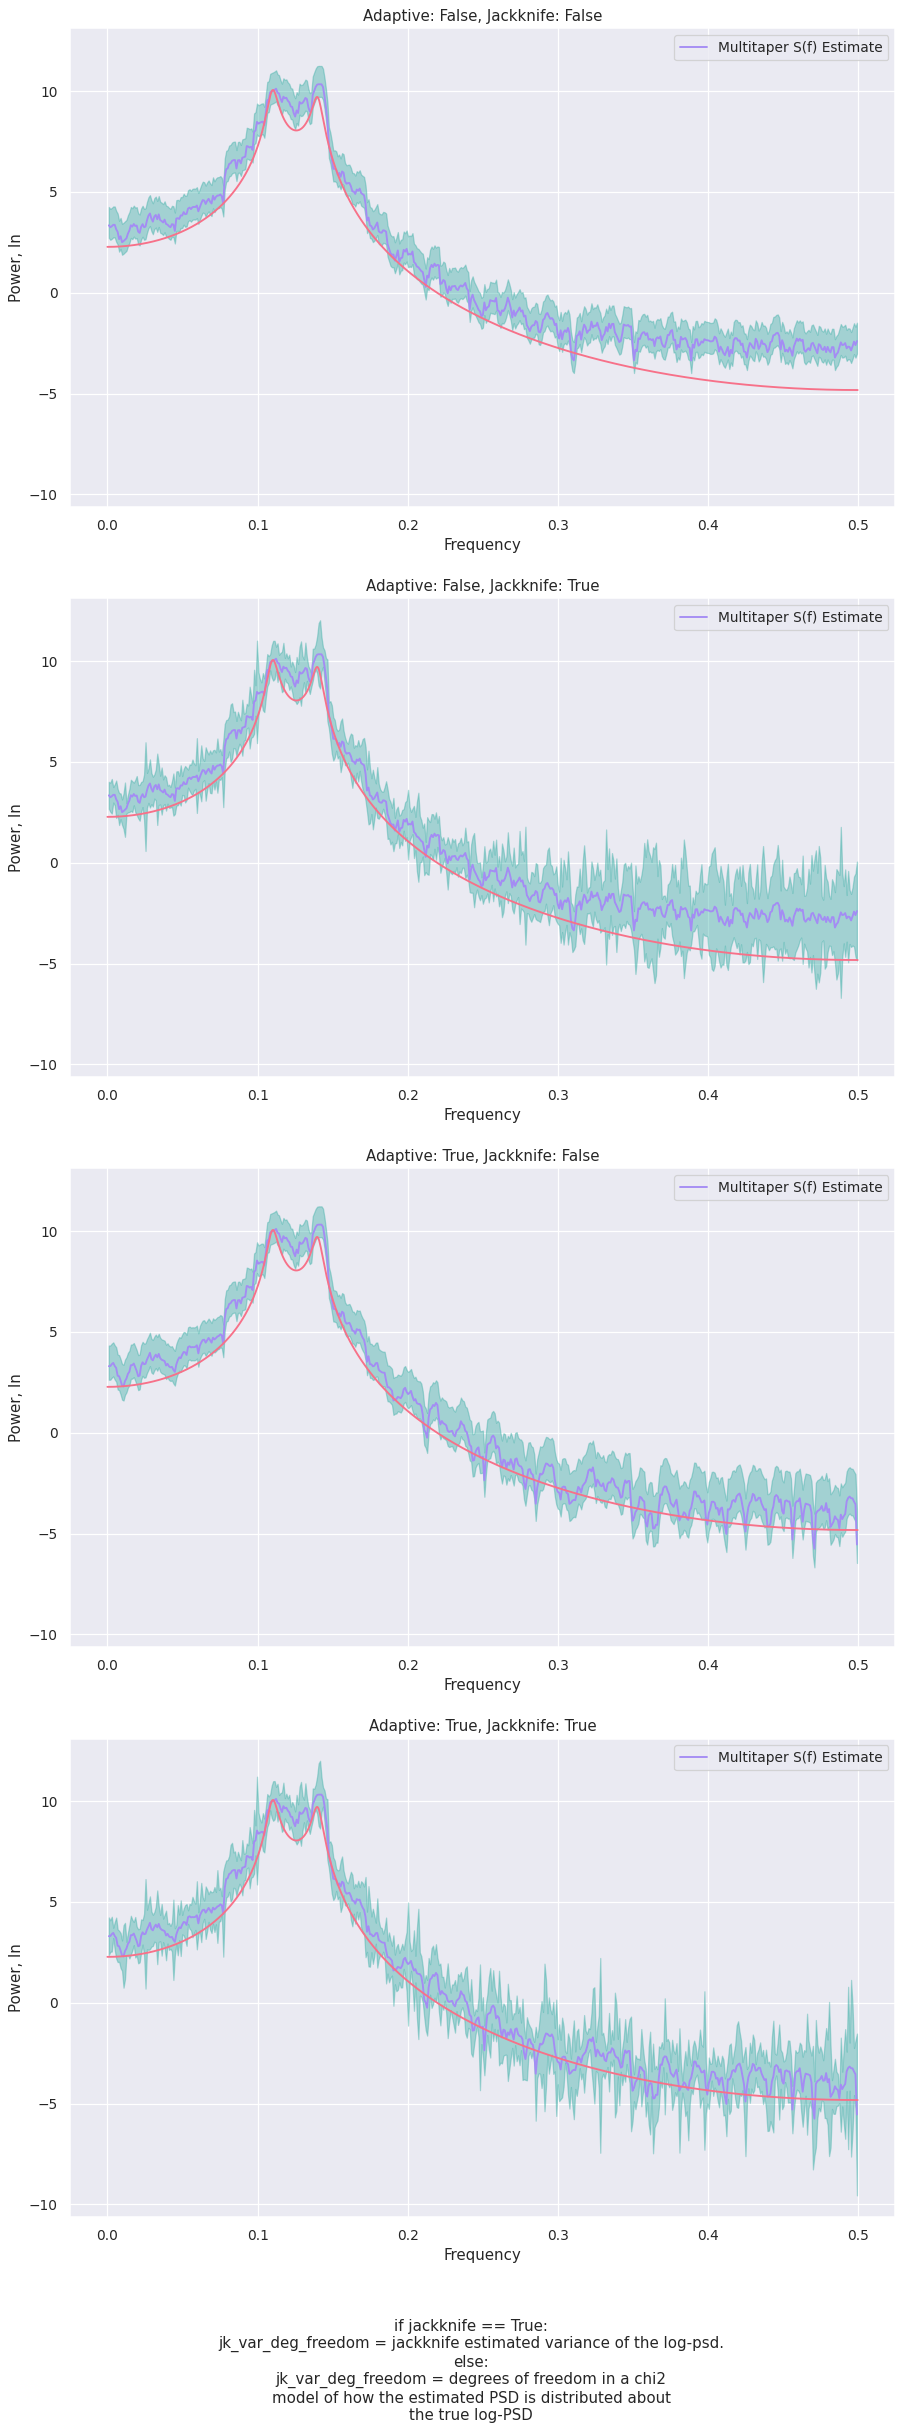

In [13]:
%%capture --no-display

# Setup utilities
import scipy.stats.distributions as dist

fig, axs = plt.subplots(4, 1, dpi=90, figsize=[11, 26], sharey=True)
fig.tight_layout(pad=4.0)

axs.flatten()
idx=0

for adaptive in (False, True):
    for jackknife in (False, True):

        mtp = Multitaper(lc_ar4, adaptive=adaptive, jackknife=jackknife)
        
        mtp_stingray = np.log(mtp.multitaper_norm_power)
        
        Kmax = len(mtp.eigvals)
        
        if jackknife:
            
            jk_p = (dist.t.ppf(.975, Kmax - 1) * np.sqrt(mtp.jk_var_deg_freedom))
            jk_limits_stingray = (mtp_stingray - jk_p, mtp_stingray + jk_p)
            
        else:
            
            p975 = dist.chi2.ppf(.975, mtp.jk_var_deg_freedom)
            p025 = dist.chi2.ppf(.025, mtp.jk_var_deg_freedom)

            l1 = np.log(mtp.jk_var_deg_freedom / p975)
            l2 = np.log(mtp.jk_var_deg_freedom / p025)

            jk_limits_stingray = (mtp_stingray + l1, mtp_stingray + l2)
            
        
        axs[idx].plot(mtp.freq, mtp_stingray, label="Multitaper S(f) Estimate", color=palette[6])
        axs[idx].fill_between(mtp.freq, jk_limits_stingray[0], y2=jk_limits_stingray[1], color=palette[4], alpha=0.4)
        
        axs[idx].plot(freq_analytical, np.log(psd_analytical), color=palette[0])
        
        axs[idx].set(
            title=f"Adaptive: {adaptive}, Jackknife: {jackknife}",
            ylabel="Power, ln",
            xlabel="Frequency"
        )
        axs[idx].legend()
        
        idx += 1
        

text = "if jackknife == True:\n\
jk_var_deg_freedom = jackknife estimated variance of the log-psd.\n\
else:\n\
jk_var_deg_freedom = degrees of freedom in a chi2\n\
model of how the estimated PSD is distributed about\n\
the true log-PSD"
fig.text(0.5, -0.05, text, ha="center")
fig.show();

### Linearly re-binning a power spectrum in frequency

Using 7 DPSS windows for multitaper spectrum estimator
Original df:  0.0009765625
Rebinned df:  0.0068359375


/tmp/ipykernel_34495/207093455.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


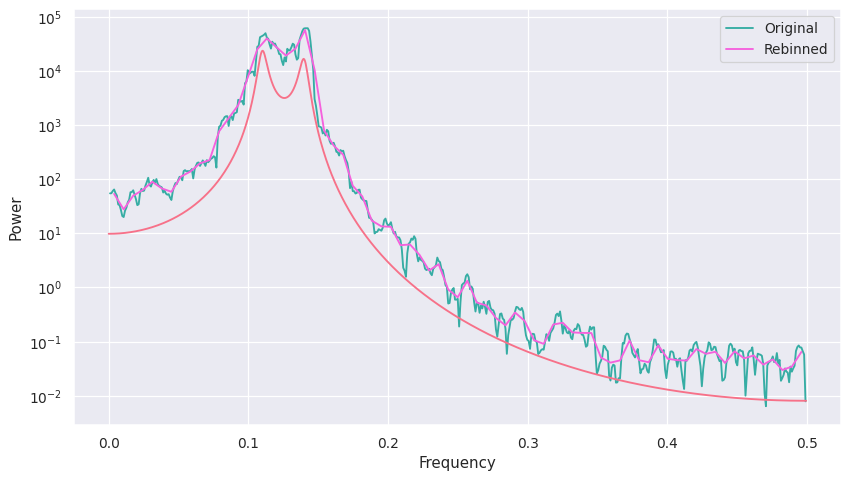

In [14]:
mtp = Multitaper(lc_ar4, adaptive=True, norm="abs")
mtp_rebin = mtp.rebin(f=7)

print("Original df: ", mtp.df)
print("Rebinned df: ", mtp_rebin.df)

f = plt.figure(dpi=90, figsize=[11, 6])
plt.plot(mtp.freq, mtp.power, label="Original", color=palette[4])
plt.plot(mtp_rebin.freq, mtp_rebin.power, label="Rebinned", color=palette[7])
plt.plot(freq_analytical, psd_analytical, color=palette[0])
plt.legend()
plt.yscale("log")
plt.ylabel("Power")
plt.xlabel("Frequency")
f.show()

### Poisson distributed lightcurve
Generate an array of relative timestamps that's 8 seconds long, with dt = 0.03125 s, and make two signals in units of counts. The signal is a sine wave with amplitude = 300 cts/s, frequency = 2 Hz, phase offset = 0 radians, and mean = 1000 cts/s. We then add Poisson noise to the light curve.

<Axes: xlabel='Time (s)', ylabel='counts'>

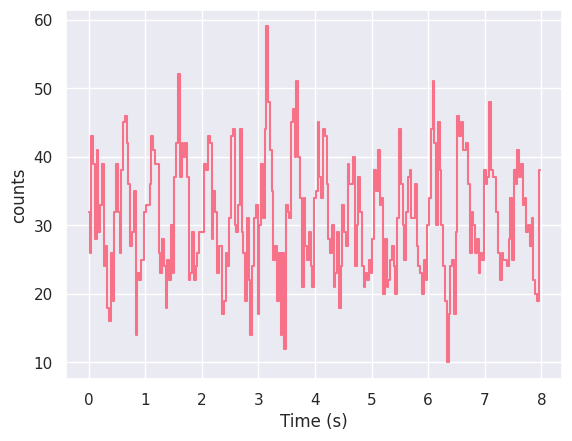

In [15]:
dt = 0.03125  # seconds
exposure = 8.  # seconds
times = np.arange(0, exposure, dt)  # seconds

signal = 300 * np.sin(2.*np.pi*times/0.5) + 1000  # counts/s
noisy = np.random.poisson(signal*dt)  # counts

lc_poisson = Lightcurve(times, noisy, dt=dt)
lc_poisson.plot()

### Comparing Powerspectrum and Multitaper on poisson-distributed lightcurve

Using 7 DPSS windows for multitaper spectrum estimator


/tmp/ipykernel_34495/2525705055.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


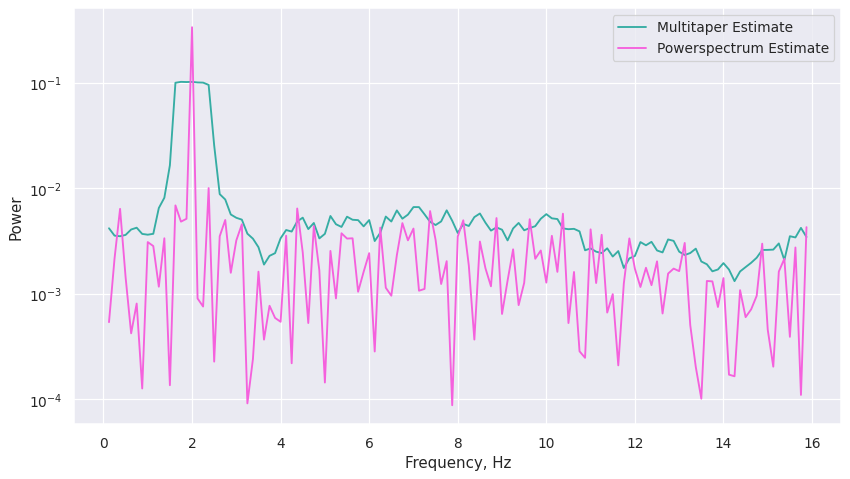

In [16]:
ps = Powerspectrum(lc_poisson)
mtp = Multitaper(lc_poisson, adaptive=True, low_bias=True)

f = plt.figure(dpi=90, figsize=[11, 6])
plt.plot(mtp.freq, mtp.power, label="Multitaper Estimate", color=palette[4])
plt.plot(ps.freq, ps.power, label="Powerspectrum Estimate", color=palette[7])
plt.legend()
plt.yscale("log")
plt.ylabel("Power")
plt.xlabel("Frequency, Hz")
f.show()

## Time series with uneven temporal sampling: Multitaper Lomb-Scargle  

Uneven temporal sampling is quite common in astronomical time series, and a popular method to deal with them is the Lomb-Scargle Periodogram.

A 2020 paper (A. Springford, et al.) used the Lomb-Scargle Periodogram in conjunction with the Multitapering concept for time-series with uneven sampling. That method is implemented here in Stingray.

Everthing works as before, just
- Create a `Lightcurve` with the unevenly sampled time-series
- Create a `Multitaper` object by passing it this `Lightcurve` object, with the desired value of NW, __just additionally pass the `lombscargle = True` keyword during instantiation.__

__NOTE__: Jack-knife variance estimation and adaptive weighting methods are not currently supported, so setting their keywords will have no effect if `lombscargle = True`.

### Testing the Multitaper Lomb-Scargle on a Kepler dataset (used in A. Springford et al. (2020) )

In [17]:
# Loading data
import pandas as pd
# If downloaded locally, use
# pd.read_csv("koi2133.csv")
kepler_data = pd.read_csv("https://raw.githubusercontent.com/StingraySoftware/notebooks/main/Multitaper/koi2133.csv")
times_kp = np.array(kepler_data["times"])
flux_kp = np.array(kepler_data["flux"])

/home/saurav/.local/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/saurav/.local/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<Axes: xlabel='Time (s)', ylabel='counts'>

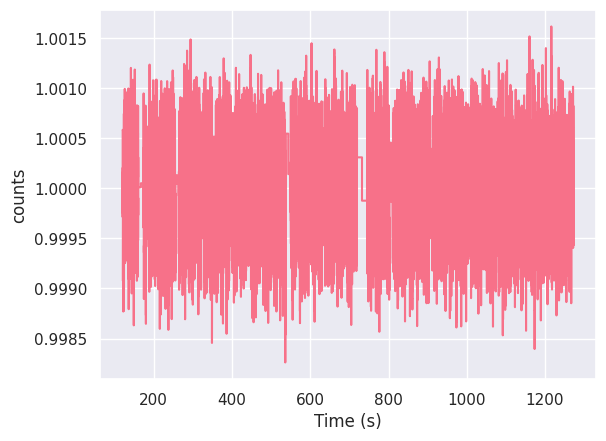

In [18]:
lc_kepler = Lightcurve(time=times_kp, counts=flux_kp, err_dist="gauss", err=np.ones_like(times_kp))
lc_kepler.plot()

##### Plotting the first 3000 data points of the kepler lightcurve
The unevenness of the temporal sampling can be better seen with this

Text(0.5, 0, 'Days')

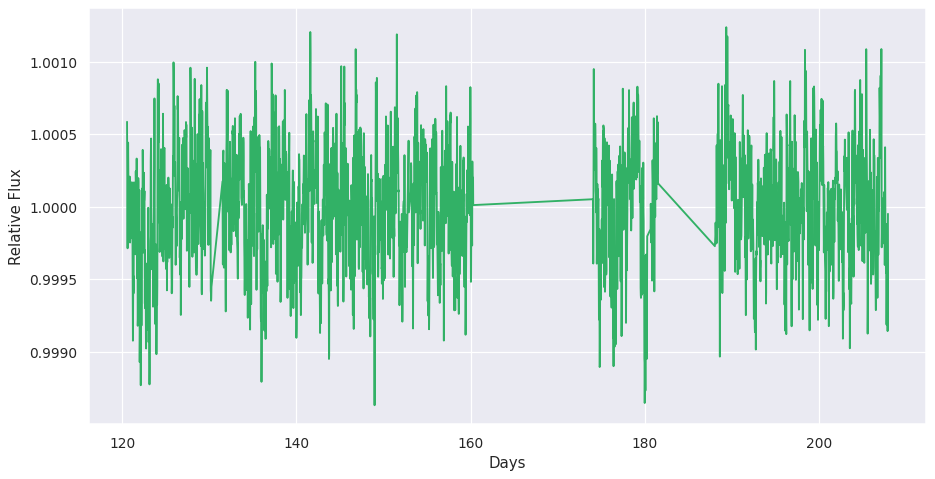

In [19]:
f = plt.figure(dpi=90, figsize=[12, 6])
plt.plot(lc_kepler.time[:3000], lc_kepler.counts[:3000], color=palette[3]);
plt.ylabel("Relative Flux")
plt.xlabel("Days")

In [20]:
%%time
mtls_kepler = Multitaper(lc_kepler, NW=10, lombscargle=True, norm="leahy") # Using normalized half bandwidth = 10

Using 19 DPSS windows for multitaper spectrum estimator
CPU times: user 2.92 s, sys: 2.74 s, total: 5.67 s
Wall time: 2.47 s


/home/saurav/.local/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


As stated before, the `adaptive` weighting method and `jackknife` log-psd estimate are currently not supported, hence these keywords will have no effect, no matter their value.

/tmp/ipykernel_34495/4057126348.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


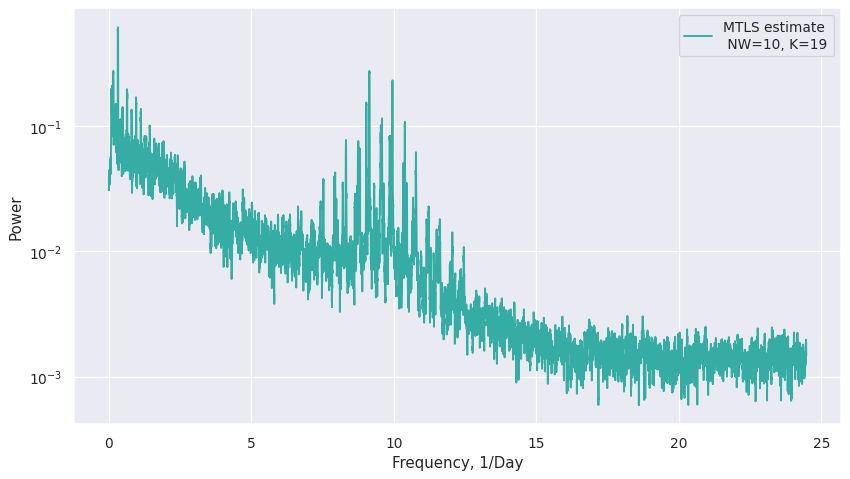

In [21]:
f = plt.figure(dpi=90, figsize=[11, 6])
plt.plot(mtls_kepler.freq, mtls_kepler.unnorm_power, label="MTLS estimate \n NW=10, K=19", color=palette[4])
plt.legend()
plt.yscale("log")
plt.ylabel("Power")
plt.xlabel("Frequency, 1/Day")
f.show()

#### But how does this compare to the classical Lomb-Scargle Periodogram?

In [22]:
from astropy.timeseries import LombScargle

ls_freq = scipy.fft.rfftfreq(n=lc_kepler.n, d=lc_kepler.dt)[1:-1] # Avioding zero
data =  lc_kepler.counts - np.mean(lc_kepler.counts)
ls_psd = LombScargle(lc_kepler.time, data).power(frequency=ls_freq, normalization="psd")

/tmp/ipykernel_34495/1461762938.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


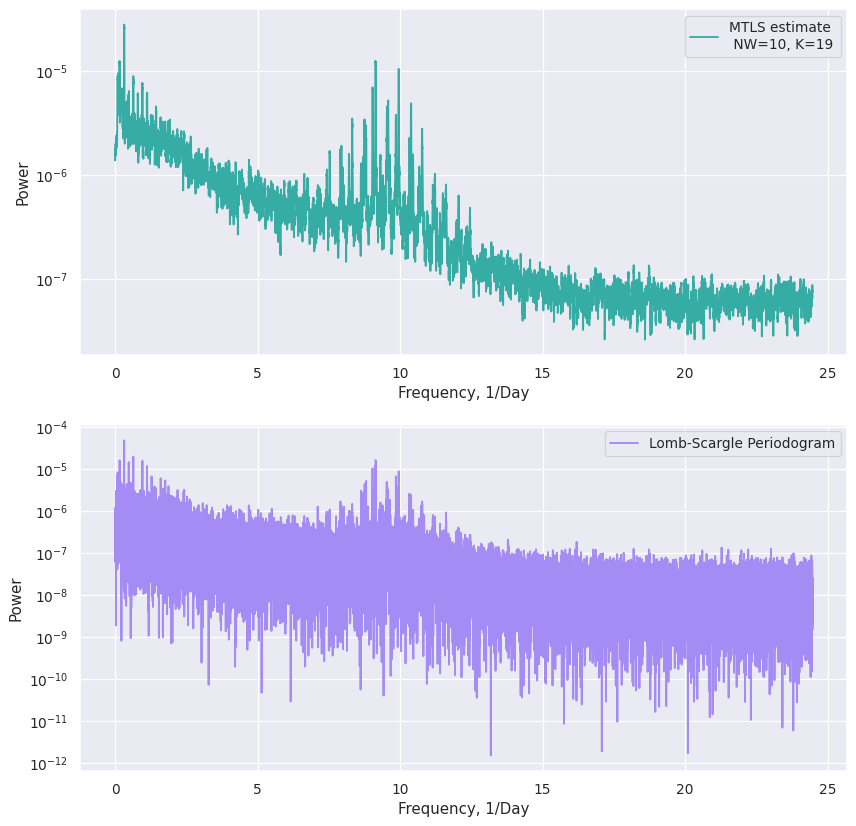

In [23]:
f, ax = plt.subplots(2, 1, dpi=90, figsize=[11, 11])
ax.flatten()
ax[0].plot(mtls_kepler.freq, mtls_kepler.power, label="MTLS estimate \n NW=10, K=19", color=palette[4])
ax[0].legend()
ax[0].set_yscale("log")
ax[0].set_ylabel("Power")
ax[0].set_xlabel("Frequency, 1/Day")

ax[1].plot(ls_freq, ls_psd, label="Lomb-Scargle Periodogram", color=palette[6])
ax[1].legend()
ax[1].set_ylabel("Power")
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency, 1/Day")
f.show()

A pretty visual reduction in variance can be seen

##### Zooming in

/tmp/ipykernel_34495/3888032190.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


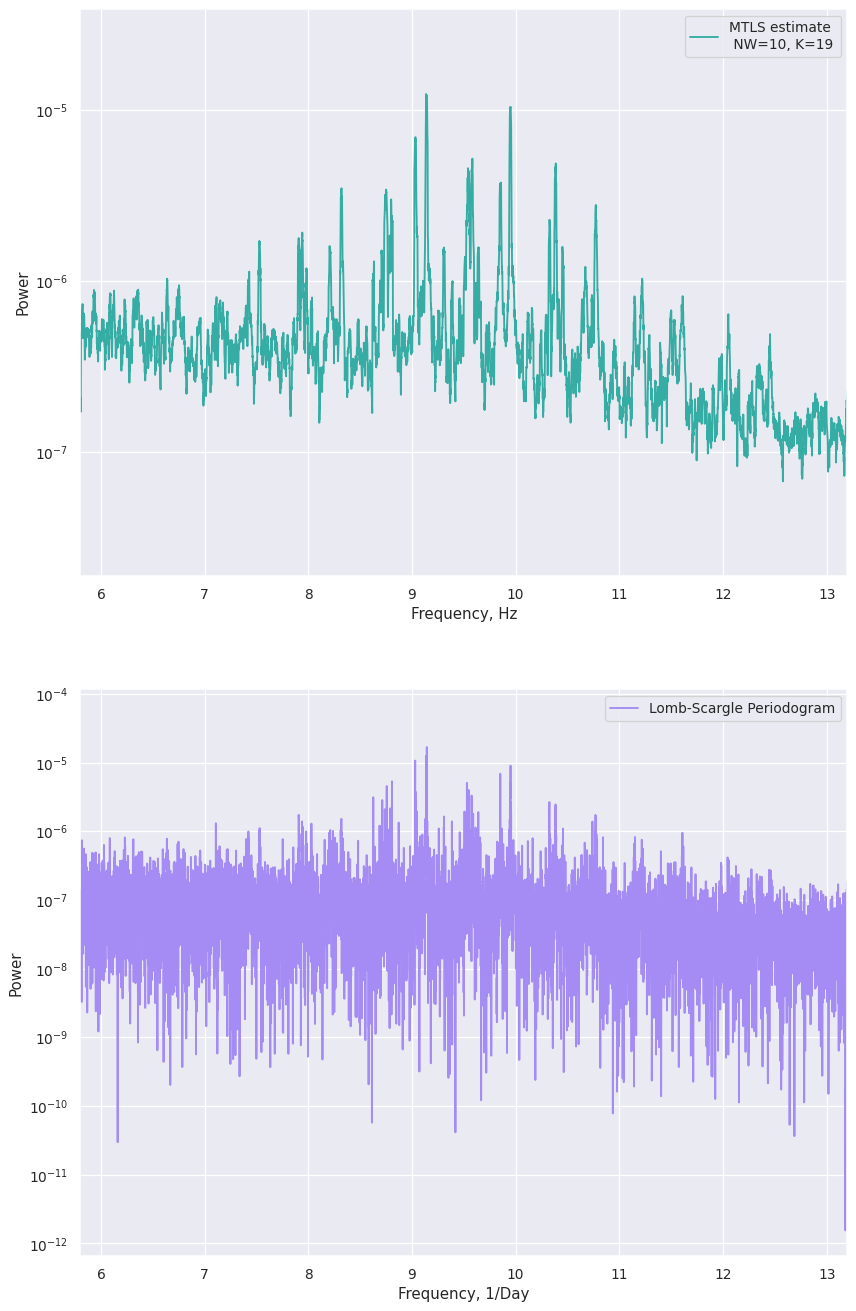

In [24]:
f, ax = plt.subplots(2, 1, dpi=90, figsize=[11, 18])
ax.flatten()
ax[0].plot(mtls_kepler.freq, mtls_kepler.power, label="MTLS estimate \n NW=10, K=19", color=palette[4])
ax[0].legend()
ax[0].set_ylabel("Power")
ax[0].set_xlabel("Frequency, Hz")
ax[0].set_yscale("log")
ax[0].set_xlim([5.8, 13.2])

ax[1].plot(ls_freq, ls_psd, label="Lomb-Scargle Periodogram", color=palette[6])
ax[1].legend()
ax[1].set_ylabel("Power")
ax[1].set_xlabel("Frequency, 1/Day")
ax[1].set_yscale("log")
ax[1].set_xlim([5.8, 13.2])
f.show()

## References

[1] Springford, Aaron, Gwendolyn M. Eadie, and David J. Thomson. 2020. “Improving the Lomb–Scargle 
Periodogram with the Thomson Multitaper.” The Astronomical Journal (American Astronomical 
Society) 159: 205. doi:10.3847/1538-3881/ab7fa1.

[2] Huppenkothen, Daniela, Matteo Bachetti, Abigail L. Stevens, Simone Migliari, Paul Balm, Omar Hammad, 
Usman Mahmood Khan, et al. 2019. “Stingray: A Modern Python Library for Spectral Timing.” The 
Astrophysical Journal (American Astronomical Society) 881: 39. doi:10.3847/1538-4357/ab258d.

[3] Thomson, D. J. 1982. “Spectrum Estimation and Harmonic Analysis.” IEEE Proceedings 70: 1055-1096. 
https://ui.adsabs.harvard.edu/abs/1982IEEEP..70.1055T.

[4] Thomson, D. J. 1990 “Time series analysis of Holocene climate data.” Philosophical Transactions of the Royal Society of 
London. Series A, Mathematical and Physical Sciences (The Royal Society) 330: 601–616. 
doi:10.1098/rsta.1990.0041.

[5] Lomb, N. R. 1976. “Least-squares frequency analysis of unequally spaced data.” Astrophysics and Space 
Science (Springer Science and Business Media LLC) 39: 447–462. doi:10.1007/bf00648343.

[6] Scargle, J. D. 1982. “Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of 
unevenly spaced data.” The Astrophysical Journal (American Astronomical Society) 263: 835. 
doi:10.1086/160554.

[7] Slepian, D. 1978. “Prolate Spheroidal Wave Functions, Fourier Analysis, and Uncertainty-V: The Discrete 
Case.” Bell System Technical Journal (Institute of Electrical and Electronics Engineers (IEEE)) 57: 
1371–1430. doi:10.1002/j.1538-7305.1978.tb02104.x.

[8] D. J. Thomson, "Jackknifing Multitaper Spectrum Estimates," in IEEE Signal Processing Magazine, vol. 24, no. 4, pp. 20-30, July 2007, doi: 10.1109/MSP.2007.4286561.